# Predict App popularity

This analytics report will analyze the influential factors for app popularity in googleplay store and build a model to predict the popularity of an app. 

## 1.Set up

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
%matplotlib inline  
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb
warnings.filterwarnings("ignore")

## 2.Load data

In [44]:
data=pd.read_csv('googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


## 3.Deal with messy data

In [46]:
for col in data.columns:
    print(data[col].unique())

['Photo Editor & Candy Camera & Grid & ScrapBook' 'Coloring book moana'
 'U Launcher Lite – FREE Live Cool Themes, Hide Apps' ...
 'Parkinson Exercices FR' 'The SCP Foundation DB fr nn5n'
 'iHoroscope - 2018 Daily Horoscope & Astrology']
['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION' '1.9']
[ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   nan  4.8  4.9
  3.6  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.
  2.9  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]
['159' '967' '87510' ... '603' '1195' '398307']
['19M' '14M' '8.7M' '25M' '2.8M' '

As we can see from the unique value in each column, some messy data exist here. For example, the column 'Size', the unit is different (M and k). Therefore, we need to uniform the unit and change the type continuous variable to float, and the datetime data to the type 'datetime'.

In [47]:
#Define a function to change value to datetime type.
from datetime import datetime
def convert_datetime(x):
    y=datetime.strptime(x,'%B %d, %Y')
    return y
#Define a function to change the unit of size column from 'M' to 'k'
def change_unit(item):
    if 'M' in item:
        item=float(item.replace('M',''))*1024
        item=str(item)
    else:
        item=item
    return item

In [48]:
#Rename the column 'Size' to Size_k
data=data.rename(columns={'Size':'Size_k'})
data['Last Updated'].loc[data['Last Updated']=='1.0.19']
#Remove outliers
data.drop(index=10472,axis=0,inplace=True)
#COnvert last updated time to datetime type
data['Last Updated']=data['Last Updated'].apply(convert_datetime)
data['Last Updated']=pd.to_datetime(data['Last Updated'])
date_max=data['Last Updated'].max()
#Create a new column name for 'TimeDelta' to calculate the days between the latest date in the column and the update date.
data['TimeDelta']=date_max-data['Last Updated']
#Uniform the unit of size column
data['Size_k']=data['Size_k'].apply(change_unit)
numerical_col=['Reviews','Size_k','Installs','Price']
#Uniform data representation and change numerical column to float type
for col in numerical_col:
    data[col]=data[col].str.replace('M','').str.replace('k','').str.replace(',','').str.replace('$','').str.replace('+','').str.replace('Free','0').str.strip().str.replace(' ','')
#Change the type of numerical columns
data_1=data.copy()
for col in numerical_col:
    data_1.loc[data_1[col]=='',col]=np.nan
    data_1.loc[data_1[col]=='Everyone',col]=np.nan
    data_1.loc[data_1[col]=='Varieswithdevice',col]=np.nan
for col in ['Current Ver','Android Ver']:
    data_1.loc[data_1[col]=='NaN',col]=np.nan
for col in numerical_col:
    data_1[col]=data_1[col].astype(float)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   App             10840 non-null  object         
 1   Category        10840 non-null  object         
 2   Rating          9366 non-null   float64        
 3   Reviews         10840 non-null  float64        
 4   Size_k          9145 non-null   float64        
 5   Installs        10840 non-null  float64        
 6   Type            10839 non-null  object         
 7   Price           10840 non-null  float64        
 8   Content Rating  10840 non-null  object         
 9   Genres          10840 non-null  object         
 10  Last Updated    10840 non-null  datetime64[ns] 
 11  Current Ver     10832 non-null  object         
 12  Android Ver     10838 non-null  object         
 13  TimeDelta       10840 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float64(5), obje

In [49]:
data_1.head()

,App,Category,Rating,Reviews,Size_k,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,TimeDelta
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19456.0,10000.0,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,213 days
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14336.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,205 days
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8908.8,5000000.0,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,7 days
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25600.0,50000000.0,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,61 days
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2867.2,100000.0,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,49 days


The messy data has been cleaned and the data type has been unified.

## 3.Explorative data analysis

I choose the number of 'Installs' as metric to evaluate the popularity.

### 1) Popularity in different categories and genres

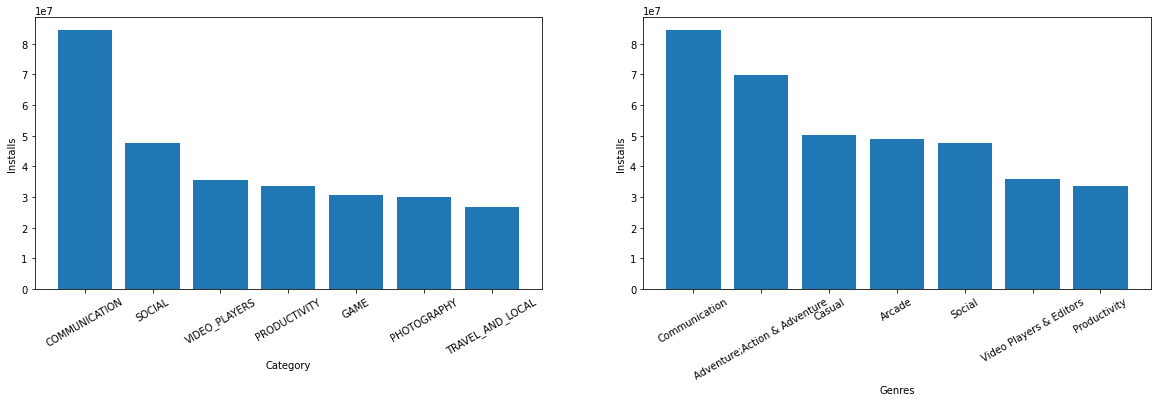

In [116]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
cat=data_1.groupby('Category')['Installs'].mean()
cat=cat.sort_values(ascending=False)[:7]
ax[0].bar(cat.index,cat.values)
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Installs')
ax[0].set_xticklabels(labels=cat.index[:7],rotation=30)
g=data_1.groupby('Genres')['Installs'].mean()
g=g.sort_values(ascending=False)[:7]
ax[1].bar(g.index,g.values)
ax[1].set_xlabel('Genres')
ax[1].set_ylabel('Installs')
ax[1].set_xticklabels(labels=g.index[:7],rotation=30)
plt.show()

From the graph, we know that the communication, adventure, social and casual are the most popular categories and genres. The communication are the most popular ones both in the Category and in Genres. Therefore, we can predict that apps belongs to the communication category has high possibility to be the most popular apps.

### 2)Content rating

In [174]:
cus=data_1.groupby('Content Rating')['Installs'].sum()
number=data_1.groupby('Content Rating')['App'].count()
cus=cat.sort_values(ascending=False)[:7]
cus=cat.sort_values(ascending=False)[:7]
df=pd.DataFrame({'Installs':cus})
df['Number of apps']=number
df=df.reset_index()
df

,Content Rating,Installs,Number of apps
0,Everyone 10+,3.196590e+07,414
1,Teen,2.873870e+07,1208
2,Everyone,1.310037e+07,8714
3,Mature 17+,1.107112e+07,499
4,Adults only 18+,6.666667e+05,3
5,Unrated,2.525000e+04,2


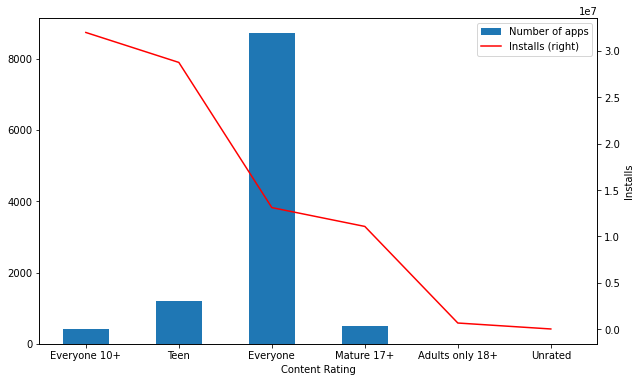

In [176]:
ax=df.plot(x='Content Rating',y='Number of apps',kind='bar',figsize=(10,6))
ax2=df.plot(x = 'Content Rating',
                   y = 'Installs',
            secondary_y = True,ax=ax, color='red')
plt.ylabel('Installs')
plt.xticks(rotation=20)
plt.show()

As we can see from the graph, the content rating of 'everyone' contains the largest number of apps. However, content rating of 'Everyone 10+' have the largest average installs. We can predict that the most popular app will be those targeted at the customer above 10 years old.

### 3) Updating days and popularity

In [157]:
from datetime import datetime, timedelta
def days(x):
    if x<=timedelta(days=200):
        d='<200days'
    elif  timedelta(days=200)<x<=timedelta(days=400):
        d='200-400days'
    elif  timedelta(days=400)<x<=timedelta(days=600):
        d='400-600days'
    elif  timedelta(days=600)<x<=timedelta(days=800):
        d='600-800days'
    elif  timedelta(days=800)<x<=timedelta(days=1000):
        d='800-1000days'
    else:
        d='>1000days'
    return d 
data_1['days']=data_1['TimeDelta'].apply(days)

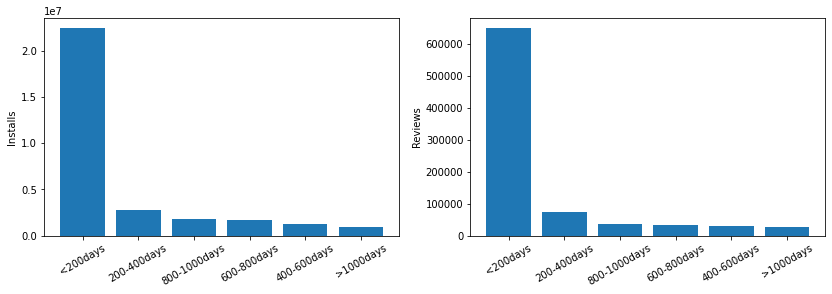

In [183]:
fig,ax=plt.subplots(1,2,figsize=(14,4))
time=data_1.groupby('days')['Installs'].mean()
time=time.sort_values(ascending=False)
re=data_1.groupby('days')['Reviews'].mean()
re=re.sort_values(ascending=False)
ax[0].bar(time.index,time.values)
ax[0].set_ylabel('Installs')
ax[0].set_xticklabels(labels=time.index,rotation=30)
ax[1].bar(re.index,re.values)
ax[1].set_xticklabels(labels=re.index,rotation=30)
ax[1].set_ylabel('Reviews')
plt.show()

As we can see from the graph, when app is updated within 200 days, the reviews and the installs are the highest. We can suggest that the later the app updates, the more popular the app is.

### 4) Continuous variable distribution

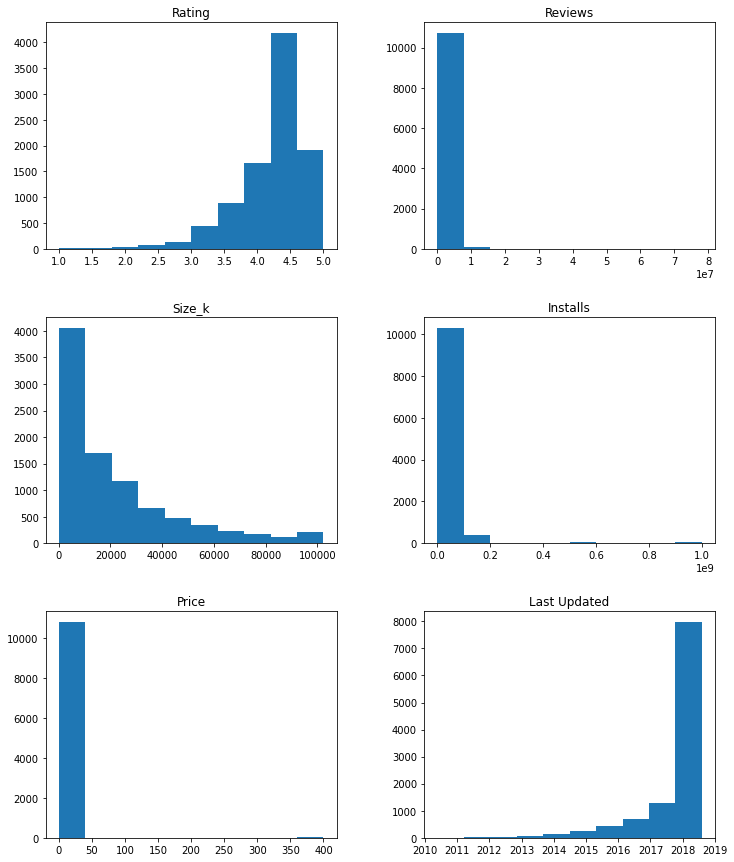

In [117]:
data_1.hist(grid=False,figsize=(12,15))
plt.show()

We can gain a general view of distribution of different features. We can detect some outliers from the graph. In the price graph, we can regard the value '350-400' as outlier. Then we are going to use statistic method to detect outliers.

## 4.Outlier detection by IQR

In [184]:
#Detect outliers
def detect_anomalies_iqr(col,k):
    ### BEGIN SOLUTION ###
    q25 = np.percentile(col,25)
    q75 = np.percentile(col,75)
    iqr = q75 - q25
    upper_limit = q75 + k * iqr
    lower_limit = q25 - k * iqr
    anomalies = list(col.index[(col>upper_limit) | (col<lower_limit)])
    return anomalies

In [186]:
all_anomalies_iqr = []
k=15 # We use a large k since the data has high variance and we are looking for extreme outliers only
for sig in ['Rating','Reviews','Size_k','Installs','Price']:
    anomalies_iqr = detect_anomalies_iqr(data_1[sig],k)
    all_anomalies_iqr += anomalies_iqr

all_anomalies_iqr = set(all_anomalies_iqr)
all_anomalies_iqr = sorted(all_anomalies_iqr)

### Remove outliers

In [187]:
#remove outliers
def remove_IQR_outliers(df):
    ### BEGIN SOLUTION ###
    # Drop outliers
    df = df.drop(all_anomalies_iqr,axis=0)
    return df
    ### END SOLUTION ###


In [188]:
data_cleaned=remove_IQR_outliers(data_1.copy())

In [189]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 10840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   App             9229 non-null   object         
 1   Category        9229 non-null   object         
 2   Rating          7908 non-null   float64        
 3   Reviews         9229 non-null   float64        
 4   Size_k          8024 non-null   float64        
 5   Installs        9229 non-null   float64        
 6   Type            9228 non-null   object         
 7   Price           9229 non-null   float64        
 8   Content Rating  9229 non-null   object         
 9   Genres          9229 non-null   object         
 10  Last Updated    9229 non-null   datetime64[ns] 
 11  Current Ver     9223 non-null   object         
 12  Android Ver     9228 non-null   object         
 13  TimeDelta       9229 non-null   timedelta64[ns]
 14  days            9229 non-null   object 

We can see from the data information, column 'rating' contains 14.31% missing values; 'Size_k' contains 13.05% missing values; Current Ver contains 0.06% missing values. The missing data will be dealt in. the next sesction.

## 5.Deal with missing data

In [243]:
cont_vars=['Rating','Reviews','Size_k']
cat_vars=['Category','Type','Content Rating','Genres','Current Ver','Android Ver','days']

For continuous variable, we will use mean value to fill missing data, for categorical variable, we will use the mode value to fill missing data.

In [244]:
def fill_missing(df_filled,undefined_flag=False):
# Replace null data in continuous features
    for col in cont_vars:
        df_filled[col] = df_filled[col].fillna(df_filled[col].mean())

    if undefined_flag==False:
    # Replace null data in categorical features
        for col in cat_vars:
            most_freq_val = df_filled[col].mode().values[0]
            df_filled[col] = df_filled[col].fillna(most_freq_val)

    else:
    # An alternative for categorical: replace null values with with new 'Undefined' category
        for col in cat_vars:
            df_filled[col] = df_filled[col].fillna('Undefined')
    return df_filled

In [245]:
data_filled=data_cleaned.copy()
data_filled=fill_missing(data_filled,undefined_flag=False)
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 10840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   App             9229 non-null   object         
 1   Category        9229 non-null   object         
 2   Rating          9229 non-null   float64        
 3   Reviews         9229 non-null   float64        
 4   Size_k          9229 non-null   float64        
 5   Installs        9229 non-null   float64        
 6   Type            9229 non-null   object         
 7   Price           9229 non-null   float64        
 8   Content Rating  9229 non-null   object         
 9   Genres          9229 non-null   object         
 10  Last Updated    9229 non-null   datetime64[ns] 
 11  Current Ver     9229 non-null   object         
 12  Android Ver     9229 non-null   object         
 13  TimeDelta       9229 non-null   timedelta64[ns]
 14  days            9229 non-null   object 

Null values have been cleaned.

## Data Preprocessing

### Bucket our target data y 

In [281]:
def bucketInstalls(x):
    if x<=10000:
        return 'Low'
    elif (x>10000 and x<=1000000):
        return 'Medium'
    elif (x>1000000):
        return 'High'

In [282]:
data_filled['Installs']=data_filled['Installs'].map(bucketInstalls)

### Split training set and test set

In [284]:
X = data_filled.drop(['Installs','Last Updated','App','Price','TimeDelta'], axis=1)
y = data_filled['Installs']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Explore the correlation between continuous variables

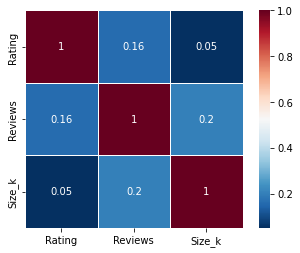

In [285]:
sns.heatmap(X_train.corr(), annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True)
plt.show()

We can see from the graph, the continous variables are independent among each other.

### Standadize continous data

In [264]:
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std[cont_vars]:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()    
    return df_std

In [265]:
X_train_scale=z_score(X_train)
X_test_scale=z_score(X_test)

In [266]:
X_train_scale.head()

,Category,Rating,Reviews,Size_k,Type,Content Rating,Genres,Current Ver,Android Ver,days
4659,FINANCE,-0.956101,-0.422395,-0.369514,Free,Everyone,Finance,4.16.10,4.4 and up,<200days
7921,FINANCE,-0.132492,-0.421289,-0.655083,Free,Everyone,Finance,5.0.0,4.4 and up,<200days
1175,FINANCE,-0.132492,-0.369055,0.181584,Free,Everyone,Finance,6.29.37589,5.0 and up,<200days
7508,LIFESTYLE,-0.132492,-0.384206,-0.002176,Free,Mature 17+,Lifestyle,Varies with device,Varies with device,<200days
1619,LIFESTYLE,-0.338395,-0.382801,-0.795363,Free,Teen,Lifestyle,1.37,4.0 and up,200-400days


### Encode categorical feature for training data

In [267]:
onehotcols = ['Category','Type','Content Rating','Genres']
ordinal_cols = ['Current Ver','Android Ver','days']

In [268]:
def onehot_encode(X,cols):
    # Treat new categories as a new 'unknown' category (all onehot columns are 0)
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    # Fit encoder on training data
    onehot_enc.fit(X[cols])
    # Get the names of the new columns created
    colnames = columns=list(onehot_enc.get_feature_names(input_features=cols))
    # Transform the data
    onehot_vals = onehot_enc.transform(X[cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(cols,axis=1)
    return X,onehot_enc

In [269]:
X_train_encoded=X_train_scale.copy()
X_train_encoded, onehot_enc = onehot_encode(X_train_encoded,onehotcols)
X_train_encoded.head()

,Rating,Reviews,Size_k,Current Ver,Android Ver,days,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
4659,-0.956101,-0.422395,-0.369514,4.16.10,4.4 and up,<200days,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7921,-0.132492,-0.421289,-0.655083,5.0.0,4.4 and up,<200days,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1175,-0.132492,-0.369055,0.181584,6.29.37589,5.0 and up,<200days,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7508,-0.132492,-0.384206,-0.002176,Varies with device,Varies with device,<200days,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1619,-0.338395,-0.382801,-0.795363,1.37,4.0 and up,200-400days,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
def ordinal_encode(X,cols):
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    # Fit the encoder on training data and transform it.  We can also use it to transform test data
    X[cols] = enc.fit_transform(X[cols])
    return X,enc


In [271]:
X_train_encoded,ordinal_enc = ordinal_encode(X_train_encoded,ordinal_cols)
X_train_encoded.head()

,Rating,Reviews,Size_k,Current Ver,Android Ver,days,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
4659,-0.956101,-0.422395,-0.369514,1545.0,19.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7921,-0.132492,-0.421289,-0.655083,1700.0,19.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1175,-0.132492,-0.369055,0.181584,1893.0,24.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7508,-0.132492,-0.384206,-0.002176,2145.0,31.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1619,-0.338395,-0.382801,-0.795363,452.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encode categorical feature for test data

In [272]:
def encode_test_set(X,ordinal_cols,onehot_cols,ordinal_encoder,onehot_encoder):
    ### BEGIN SOLUTION ###
    
    # Apply ordinal encoder
    X[ordinal_cols] = ordinal_encoder.transform(X[ordinal_cols])
    
    # Apply onehot encoder
    colnames = columns=list(onehot_encoder.get_feature_names(input_features=onehot_cols))
    onehot_vals = onehot_encoder.transform(X[onehot_cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(onehot_cols,axis=1)
    
    return X
    ### END SOLUTION ###

In [274]:
X_test_encoded = X_test_scale.copy()
X_test_encoded = encode_test_set(X_test_encoded,ordinal_cols,onehotcols,ordinal_enc,onehot_enc)
display(X_test_encoded.head())

,Rating,Reviews,Size_k,Current Ver,Android Ver,days,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
593,0.083642,-0.379947,0.891544,1404.0,16.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6075,0.280657,3.914583,1.641094,1554.0,15.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6803,0.010720,-0.420045,-0.996482,2145.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
891,0.083642,0.596029,0.008680,831.0,16.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3840,1.068718,0.841197,1.391244,-1.0,19.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build baseline model

In [286]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [287]:
lg=LogisticRegression()
rf = RandomForestClassifier()
svc=SVC()
for model in [lg,rf,svc]:
    scores = cross_val_score(model,X_train_encoded,y_train,scoring='accuracy',cv=3)
    mean_score = np.mean(scores)
    print(model)
    print('Mean cross-validation accuracy across all folds is {:.3f} \n'.format(mean_score))



LogisticRegression()
Mean cross-validation accuracy across all folds is 0.643 

RandomForestClassifier()
Mean cross-validation accuracy across all folds is 0.894 

SVC()
Mean cross-validation accuracy across all folds is 0.515 



### Plot RandomForestClassifier confusion matrix

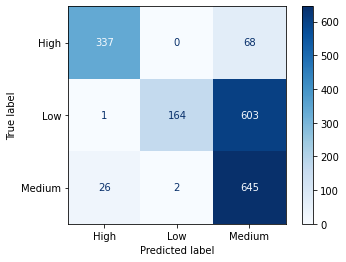

In [291]:
from sklearn.metrics import plot_confusion_matrix
rf.fit(X_train_encoded,y_train)
plot_confusion_matrix(rf, X_test_encoded, y_test,cmap=plt.cm.Blues,normalize=None)
plt.show()

In [295]:
from sklearn.metrics import roc_auc_score,accuracy_score
preds=rf.predict(X_test_encoded)
preds_pro=rf.predict_proba(X_test_encoded)
roc_auc=roc_auc_score(y_test,preds_pro,multi_class='ovo', average='weighted')
acc=accuracy_score(y_test,preds)
print('The roc_auc score is {:.2f} and the accuracy score is {:.2f}'.format(roc_auc,acc))

The roc_auc score is 0.94 and the accuracy score is 0.62


As we can see from the confusion matrix, the general result is good. However, the model is not good at classifing low and medium. 